# PPP Calculations


Calculating and masking PPP. All plotting methods in other notebooks simply take a PPP xarray as parameters, so you have some flexibility in masking/not masking.

In [13]:
# Importing packages
import math
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import nc_time_axis
from dask.diagnostics import ProgressBar
import re
from xmovie import Movie
%matplotlib inline
import imageio
import math
import pandas as pd


#cartopy
from cartopy import crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point

THRESHOLD = 0.235559205

In [14]:
gridpath = ('/projects/SOCCOM/data/ESM4_PPE/archive/Richard.Slater/xanadu_esm4_20190304_mom6_ESM4_v1.0.3_rc1/GRID/ocean.static.nc')
grid = xr.open_dataset(gridpath)
rootdir = ('/projects/SOCCOM/data/ESM4_PPE/archive/Richard.Slater/xanadu_esm4_20190304_mom6_ESM4_v1.0.3_rc1/ESM4_piControl_D/gfdl.ncrc4-intel18-prod-openmp/pp/')
ppname = 'ocean_month'
ppname2 = 'ocean_cobalt_omip_2d'
ppname3 = 'ocean_cobalt_omip_sfc'
localdir = '/ts/monthly/5yr/'

## Helper Functions for Intermediate Steps in PPP calculation:

In [15]:
# minor helper method - returns the ppname for a particular driver
# called when opening up datasets
def pp(driver):
    if driver=='tos' or driver=='sos' or driver=='MLD_003':
        return 'ocean_month'
    elif re.search('intpp*',driver):
        return 'ocean_cobalt_omip_2d'
    elif re.search('os',driver):
        return 'ocean_cobalt_omip_sfc'

    
# returns the variance for a particular ensemble start year
def ens_var(start_year, driver_global, driver):
    # create a list of xarrays of control + ensemble data to be concatenated
    members = [*range(10)]
    ppname = pp(driver)
    
    # Take the corresponding 10 year slice from the Control Run, add it to list of members
    end = '0' + str(int(start_year) + 9)
    ctrl_slice = driver_global.sel(time=slice(start_year+'-01-16',end+'-12-16'))
    members[0] = ctrl_slice
    
    # loop through all 9 ensemble members
    for member in range(1,len(members)):
        folder = 'ESM4_piControl_D-ensemble-' + start_year + '0101-0' + str(member)
        path = ('/projects/SOCCOM/data/ESM4_PPE/archive/Richard.Slater/xanadu_esm4_20190304_mom6_ESM4_v1.0.3_rc1/'
                +folder+'/gfdl.ncrc4-intel18-prod-openmp/pp/'+ppname+'/ts/monthly/5yr/'+ppname+'.*'+driver+'.nc')
        ens_mem = xr.open_mfdataset(path)
        members[member] = ens_mem
        
    # combine all ensemble members and control into one xarray
    all_members = xr.concat(members,dim='members')
    
    # compute the variance
    variance = (all_members.std(dim='members')) ** 2
    
    return variance
    

# Returns the average ensemble variance at each timestep over all start years
# Averages the ensemble variances computed using ens_var() above
STARTS = ['0123','0161','0185','0208','0230','0269','0300','0326','0359','0381']
def avg_ens_var(driver_global, driver):
    # initialize total to be stddev of first ensemble - year '0123'
    ensembles = [*range(len(STARTS))]
    timei = np.arange(120)
    
    for ens in range(len(ensembles)):
        time_adjusted = ens_var(STARTS[ens],driver_global,driver).assign_coords(time=timei)
        ensembles[ens] = time_adjusted
    
    total = xr.concat(ensembles,dim='ensemble')
    avg = total.mean(dim='ensemble')
    
    return avg


In [16]:
# returns the variance for a particular ensemble start year
def ens_var(start_year, driver_global, driver):
    # create a list of xarrays of control + ensemble data to be concatenated
    members = [*range(10)]
    ppname = pp(driver)
    
    # Take the corresponding 10 year slice from the Control Run, add it to list of members
    end = '0' + str(int(start_year) + 9)
    ctrl_slice = driver_global.sel(time=slice(start_year+'-01-16',end+'-12-16'))
    members[0] = ctrl_slice
    
    # loop through all 9 ensemble members
    for member in range(1,len(members)):
        folder = 'ESM4_piControl_D-ensemble-' + start_year + '0101-0' + str(member)
        path = ('/projects/SOCCOM/data/ESM4_PPE/archive/Richard.Slater/xanadu_esm4_20190304_mom6_ESM4_v1.0.3_rc1/'
                +folder+'/gfdl.ncrc4-intel18-prod-openmp/pp/'+ppname+'/ts/monthly/5yr/'+ppname+'.*'+driver+'.nc')
        ens_mem = xr.open_mfdataset(path)
        members[member] = ens_mem
        
    # combine all ensemble members and control into one xarray
    all_members = xr.concat(members,dim='members')
    
    # compute the variance
    variance = (all_members.std(dim='members')) ** 2
    
    return variance
    


In [17]:
STARTS = ['0123','0161','0185','0208','0230','0269','0300','0326','0359','0381']
def avg_ens_var(driver_global, driver):
    # initialize total to be stddev of first ensemble - year '0123'
    ensembles = [*range(len(STARTS))]
    timei = np.arange(120)
    
    for ens in range(len(ensembles)):
        time_adjusted = ens_var(STARTS[ens],driver_global,driver).assign_coords(time=timei)
        ensembles[ens] = time_adjusted
    
    total = xr.concat(ensembles,dim='ensemble')
    avg = total.mean(dim='ensemble')
    
    return avg


## PPP function:

In [24]:
# Takes as parameter the name of the driver variable ex. 'tos' for SST
# or 'intpp' for Integrated Primary Production and returns
# 720x576x120 xarray Dataset (every gridpoint for all 120 months)
def ppp(driver, ogs=False):
    if ogs:
        ds = xr.open_dataset('/projects/SOCCOM/saumyam/data_netcdf_files/Control_Full/'+driver)
    else:
        ds = xr.open_mfdataset(rootdir+pp(driver)+localdir+'*'+driver+'.nc')
    ds = ds.chunk({'time':60})
    
    avg_ens = avg_ens_var(ds,driver)
    with ProgressBar():
        avg_ens = avg_ens.compute()
    timeindex = np.arange(120)
    avg_ens = avg_ens.assign_coords(time=timeindex)
    
    control_monthly = ds[driver].groupby('time.month')
    control_var_monthly = control_monthly.std() ** 2
    control_var_arr = control_var_monthly.to_numpy()
    repeated = np.tile(control_var_arr, (10,1,1))
    #xarray.repeat
    
    ctrl_var = avg_ens.copy(data={driver:repeated})
    ctrl_var = ctrl_var.assign_coords(time=timeindex)
    
    ratio = avg_ens / ctrl_var
    ppp = 1 - ratio
    return ppp

## Masking:

In [ ]:
# Helper Method
#returns control standard deviation by month
def ctrl_std(driver):
    # ds = xr.open_dataset('/projects/SOCCOM/saumyam/data_netcdf_files/Control_Full/'+driver)
    ds = xr.open_mfdataset(rootdir+pp(driver)+localdir+'*'+driver+'.nc')
    ds = ds.chunk({'time':60})

    control_monthly = ds[driver].groupby('time.month')
    control_std = control_monthly.std()

    return control_std

In [ ]:
# default percentile is 10 but can be changed
def mask(driver,driver_ppp,percentile=10):
    d_std = ctrl_std(driver)
    
    mask = np.nanpercentile(d_std,percentile,axis={1,2}) #1 and 2 corresponds to xh, yh
    
    sig = d_std.where(d_std>mask[:,np.newaxis,np.newaxis])
    
    masked_out = d_std.where(d_std<mask[:,np.newaxis,np.newaxis])
    
    # Repeat the 12 months 10 times
    repeated = np.tile(sig, (10,1,1))

    significant = driver_ppp.copy(data={driver:repeated})
    significant = significant.assign_coords(time=np.arange(120))
    
    masked = driver_ppp.where(significant>0)
    return masked

In [ ]:
# Visualize percentile cutoffs
def plot_cutoffs(driver):
    d_std = ctrl_std(driver)
    one = np.nanpercentile(d_std,1,axis={1,2}) # can change the percentiles in next 5 lines
    five = np.nanpercentile(d_std,5,axis={1,2})
    ten = np.nanpercentile(d_std,10,axis={1,2})
    fifteen = np.nanpercentile(d_std,15,axis={1,2})
    twenty = np.nanpercentile(d_std,20,axis={1,2})
    
    plt.plot(one,label='1')
    plt.plot(five,label='5')
    plt.plot(ten,label='10')
    plt.plot(fifteen,label='15')
    plt.plot(twenty,label='20')
    plt.title(driver)
    plt.legend()
    plt.xlabel('Month')
    plt.ylabel('Std Deviation Cutoff')

## Variance Weighted PPP Calculation:

In [20]:
ppps_dict = {'tos': tos_ppp, 'sos': sos_ppp, 'MLD_003': mld_ppp, 
        'intpp': npp_ppp, 'chlos': chlos_ppp, 'o2os': o2os_ppp, 'no3os': no3os_ppp, 
        'po4os': po4os_ppp, 'phos': phos_ppp, 'phycos': phycos_ppp, 'zoocos': zoocos_ppp, 'intpppico': pico_ppp, 'intppdiat': diat_ppp,
        'intppdiaz': diaz_ppp, 'intppmisc': misc_ppp}

In [20]:
#returns control variance by month, repeated for 10 years
def ctrl_var(driver,driver_ppp):
    ds = xr.open_dataset('/projects/SOCCOM/saumyam/data_netcdf_files/Control_Full/'+driver)
    ds = ds.chunk({'time':60})

    control_monthly = ds[driver].groupby('time.month')
    control_var_monthly = control_monthly.std() ** 2
    control_var_arr = control_var_monthly.to_numpy()
    repeated = np.tile(control_var_arr, (10,1,1))

    ctrl_var = driver_ppp.copy(data={driver:repeated})
    ctrl_var = ctrl_var.assign_coords(time=np.arange(120))
    return ctrl_var

In [21]:
# plots the area weighted and area*variance weighted ppp on the same plot, returns variance weighted
def plt_var_weighted(driver,ppp):
    ppp_unweighted = ppp[driver].weighted(grid['areacello']).mean(['xh','yh'])
    ppp_unweighted.plot(label='PPP, area weighted')
    #ppp_weighted.plot(label='PPP, area and variance weighted')
    weighted_ppp = ppp.weighted((ctrl_var(driver,ppp)[driver] * grid['areacello']).fillna(0)).mean(['xh','yh'])
    weighted_ppp[driver].plot(label='PPP, area and variance weighted')
    #ppp_weighted_mask.plot(label='PPP, masked and weighted')
    plt.title('Global Average of PPP, ' + driver)
    plt.xlabel('Lead Time (Months)')
    plt.ylabel('PPP')
    plt.axhline(y=THRESHOLD, color='grey', linestyle='dashed',label='Predictability Threshold')
    plt.legend()
    plt.savefig('Variance weighted PPP (global average), ' + driver)

    return weighted_ppp[driver]

/home/saumyam/.conda/envs/saumyac/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


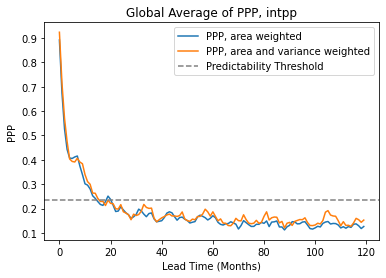

In [22]:
npp_weighted = plt_var_weighted('intpp',npp_ppp)

/home/saumyam/.conda/envs/saumyac/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


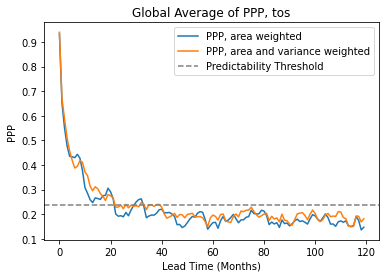

In [102]:
tos_weighted = plt_var_weighted('tos',tos_ppp)

/home/saumyam/.conda/envs/saumyac/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


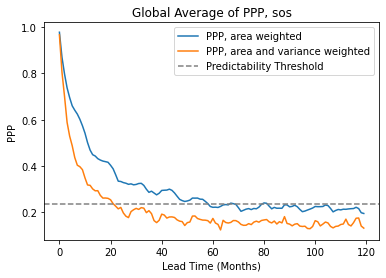

In [103]:
sos_weighted = plt_var_weighted('sos',sos_ppp)

/home/saumyam/.conda/envs/saumyac/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


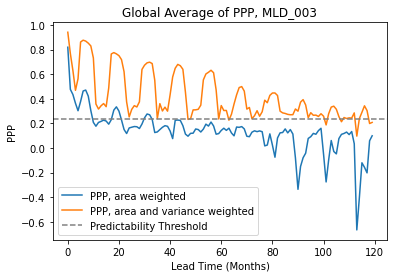

In [104]:
mld_weighted = plt_var_weighted('MLD_003',mld_ppp)

/home/saumyam/.conda/envs/saumyac/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


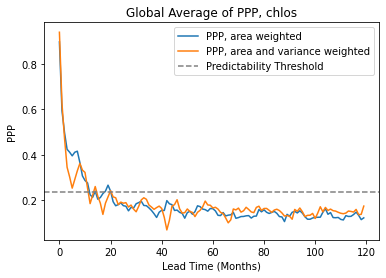

In [105]:
chlos_weighted = plt_var_weighted('chlos',chlos_ppp)

/home/saumyam/.conda/envs/saumyac/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


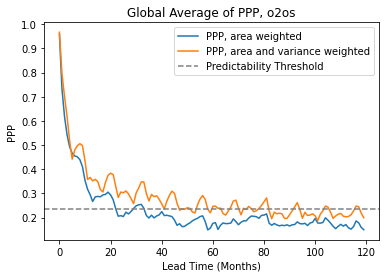

In [106]:
o2os_weighted = plt_var_weighted('o2os',o2os_ppp)

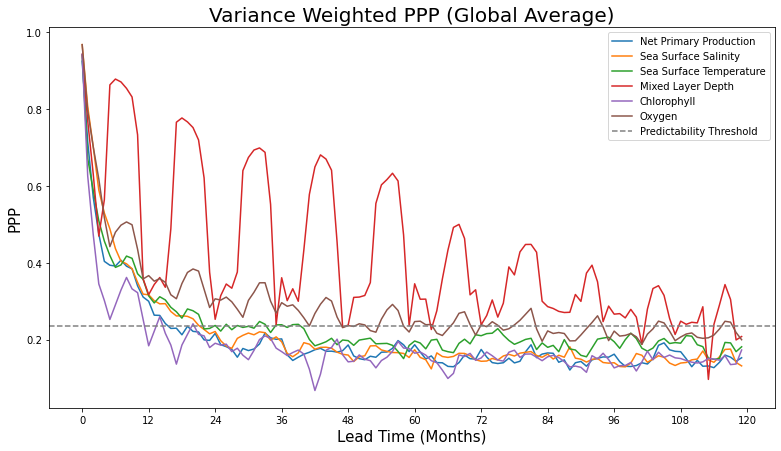

In [108]:
fig,ax = plt.subplots(1,1,figsize=(13,7))
months=[0,12,24,36,48,60,72,84,96,108,120]
ax.set_xticks(months)
npp_weighted.plot(label = 'Net Primary Production')
sos_weighted.plot(label = 'Sea Surface Salinity')
tos_weighted.plot(label = 'Sea Surface Temperature')
mld_weighted.plot(label = 'Mixed Layer Depth')
chlos_weighted.plot(label = 'Chlorophyll')
o2os_weighted.plot(label = 'Oxygen')
plt.axhline(y=THRESHOLD, color='grey', linestyle='dashed',label='Predictability Threshold')
plt.title('Variance Weighted PPP (Global Average)',fontsize=20)
plt.xlabel('Lead Time (Months)',fontsize=15)
plt.ylabel('PPP',fontsize=15)
plt.legend()
plt.savefig('Variance Weighted PPP')

# Save PPP as Movie

In [8]:
tosmaskmov = Movie(tos_ppp['tos'],vmin=0,vmax=1)
tosmaskmov.save('toss.mp4',framerate=5)

Movie created at toss.mp4


In [10]:
ppps = [tos_ppp,sos_ppp,npp_ppp,o2os_ppp,no3os_ppp,phos_ppp,chlos_ppp,po4os_ppp]
drivers = ['tos','sos','intpp','o2os','no3os','phos','chlos','po4os']

for i in range(4,len(ppps)):
    maskmov = Movie(ppps[i][drivers[i]],vmin=0,vmax=1)
    maskmov.save(drivers[i]+'pppmask.mp4',framerate=5)


RuntimeError: File `no3ospppmask.mp4` already exists. Set `overwrite_existing` to True to overwrite.